<a href="https://colab.research.google.com/github/NajwaaAzzahra/IndoCurrencyDetection/blob/main/MoneyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Najwa Azzahra
#TI-3C/19
#2241720139

# Training

In [11]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fannyzahrahramadhan/uang-emisi-2022-baru")

print("Path to dataset files:", path)

100%|██████████| 240M/240M [00:13<00:00, 19.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/fannyzahrahramadhan/uang-emisi-2022-baru/versions/1


In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

In [13]:
class Config:
    img_height = 200
    img_width = 200
    epochs = 50
    batch_size = 32
    learning_rate = 1e-3

In [14]:

dir_path = os.path.join(path,'Uang Baru')
image_paths = []

for dirname, _, filenames in os.walk(dir_path):
    for filename in filenames:
        image_path  = os.path.join(dirname, filename)
        image_paths.append(image_path)

In [15]:
df = pd.DataFrame({
    'path': image_paths
})

df['filename'] = df.path.apply(lambda x: x.split('/')[10])
df['nominal'] = df.path.apply(lambda x: x.split('/')[-1])
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,path,filename,nominal
0,/root/.cache/kagglehub/datasets/fannyzahrahram...,10 k,UANG RUPIAH 10K (149).jpeg
1,/root/.cache/kagglehub/datasets/fannyzahrahram...,50 K,UANG RUPIAH 50K (42).jpeg
2,/root/.cache/kagglehub/datasets/fannyzahrahram...,50 K,UANG RUPIAH 50K (37).jpeg
3,/root/.cache/kagglehub/datasets/fannyzahrahram...,5k,UANG RUPIAH 5000 (175).jpeg
4,/root/.cache/kagglehub/datasets/fannyzahrahram...,50 K,UANG RUPIAH 50K (53).jpeg


<BarContainer object of 7 artists>

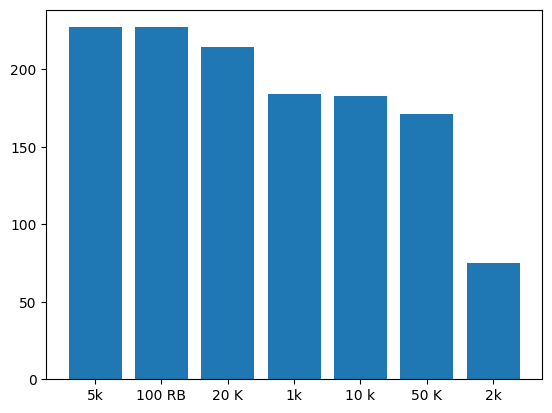

In [16]:
filename_vc = df.filename.value_counts()
plt.bar(filename_vc.index, filename_vc.values)

In [17]:
dataset = tf.keras.utils.image_dataset_from_directory(
    dir_path,
    seed=42,
    image_size=(Config.img_height, Config.img_width),
    batch_size=10
)

train_ds = tf.keras.utils.image_dataset_from_directory(
    dir_path,
    subset='training',
    validation_split=0.2,
    seed=42,
    image_size=(Config.img_height, Config.img_width),
    batch_size=Config.batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dir_path,
    subset='validation',
    validation_split=0.2,
    seed=42,
    image_size=(Config.img_height, Config.img_width),
    batch_size=Config.batch_size
)

Found 1281 files belonging to 7 classes.
Found 1281 files belonging to 7 classes.
Using 1025 files for training.
Found 1281 files belonging to 7 classes.
Using 256 files for validation.


In [18]:
currency_nominal = dataset.class_names
num_of_classes = len(currency_nominal)
currency_nominal

['10 k', '100 RB', '1k', '20 K', '2k', '50 K', '5k']

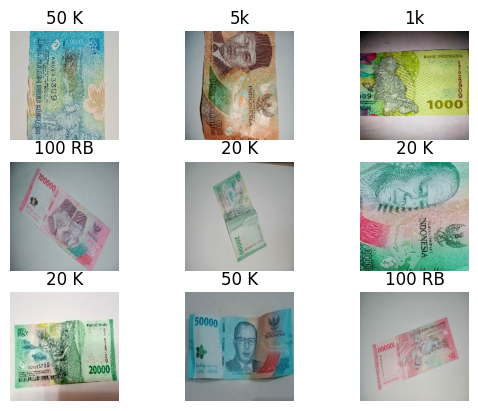

In [19]:
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(currency_nominal[labels[i]])
        plt.axis('off')


In [20]:
class myCallback(tf.keras.callbacks.Callback):
     def on_epoch_end(self, epoch,logs={}):
        if (logs.get("accuracy") > 0.90):
            print("\nStop training, accuracy > 0.90")
            self.model.stop_training = True

callback = myCallback()

In [21]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                               input_shape=(
                                   Config.img_height,
                                   Config.img_width,
                                   3)
                              ),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_of_classes)
])

In [23]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=Config.learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [24]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=Config.epochs,
    callbacks=[callback]
)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 552ms/step - accuracy: 0.1880 - loss: 1.9457 - val_accuracy: 0.1211 - val_loss: 2.0652
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 574ms/step - accuracy: 0.2157 - loss: 1.8898 - val_accuracy: 0.2578 - val_loss: 1.8974
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 618ms/step - accuracy: 0.3039 - loss: 1.7811 - val_accuracy: 0.4297 - val_loss: 1.3749
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 625ms/step - accuracy: 0.4653 - loss: 1.3449 - val_accuracy: 0.5781 - val_loss: 1.2125
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 636ms/step - accuracy: 0.6188 - loss: 1.0633 - val_accuracy: 0.7891 - val_loss: 0.5531
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 634ms/step - accuracy: 0.7930 - loss: 0.5917 - val_accuracy: 0.8242 - val_loss: 0.4621
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 638ms/step - accuracy: 0.8425 - loss: 0.4492 - val_accuracy: 0.7578 - val_loss: 0.7550
Epoch 8/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.8969 - loss: 0.3243
Stop traini

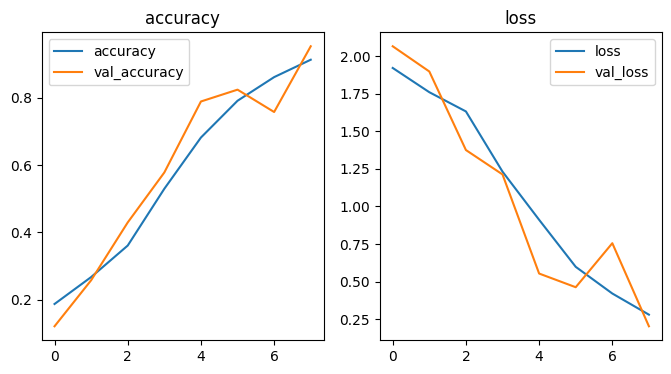

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.set_title('accuracy')
ax1.plot(model.history.history['accuracy'], label='accuracy')
ax1.plot(model.history.history['val_accuracy'], label='val_accuracy')
ax1.legend()

ax2.set_title('loss')
ax2.plot(model.history.history['loss'], label='loss')
ax2.plot(model.history.history['val_loss'], label='val_loss')
ax2.legend()

In [26]:
loss, accuracy = model.evaluate(dataset)
print('accuracy :', accuracy)
print('loss     :', loss)

129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 147ms/step - accuracy: 0.9373 - loss: 0.2273
accuracy : 0.937548816204071
loss     : 0.23454397916793823


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


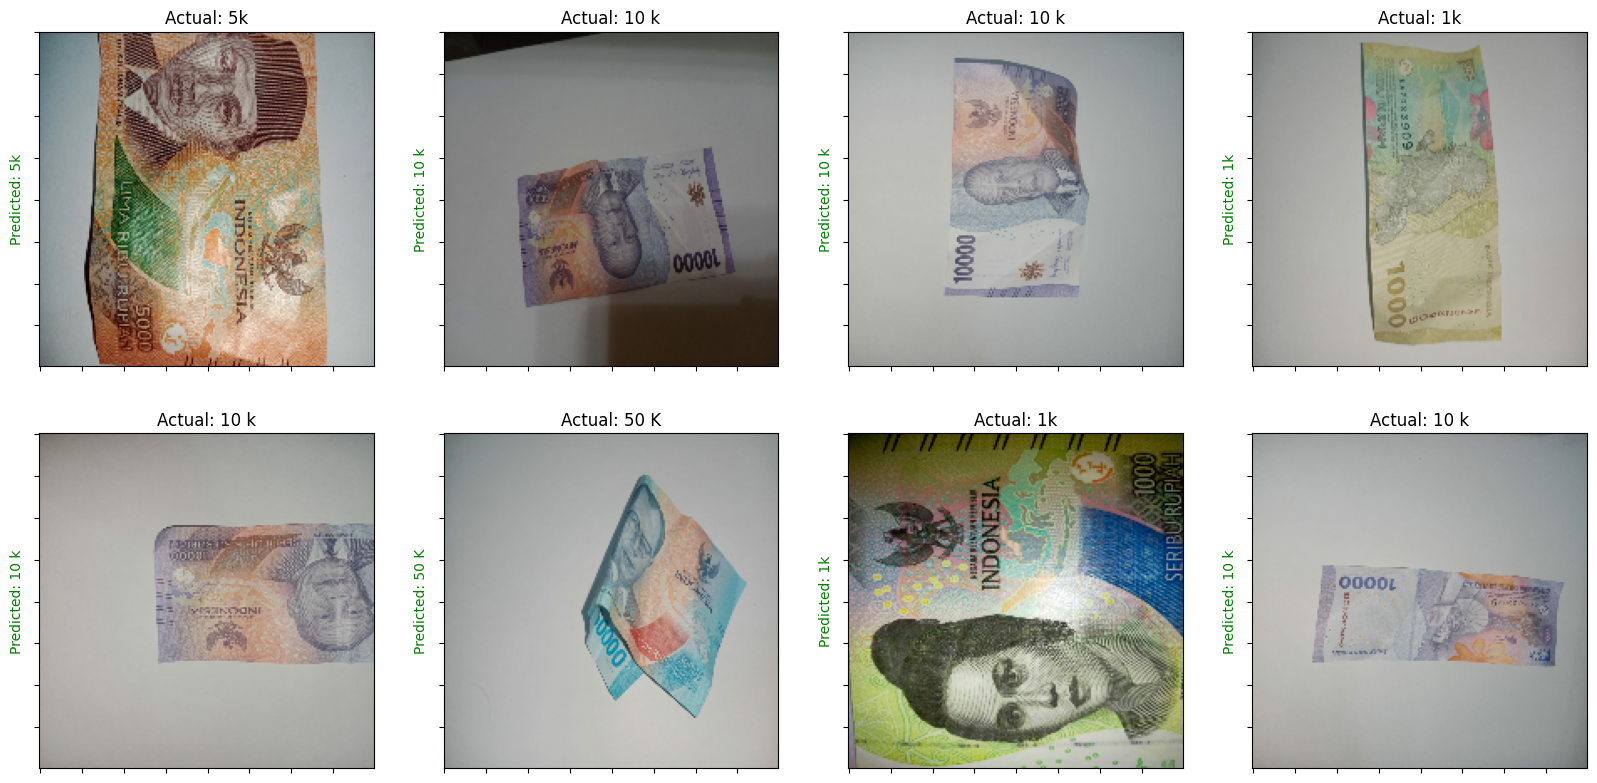

In [27]:
plt.figure(figsize=(20, 20))
for images, labels in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predictions = model.predict(tf.expand_dims(images[i], 0))
        score = tf.nn.softmax(predictions[0])

        predicted_axis_color = 'green' if currency_nominal[labels[i]] == currency_nominal[np.argmax(score)] else 'red'

        plt.title('Actual: ' + currency_nominal[labels[i]])
        plt.ylabel('Predicted: ' + currency_nominal[np.argmax(score)], fontdict={'color': predicted_axis_color})

        plt.gca().axes.xaxis.set_ticklabels([])
        plt.gca().axes.yaxis.set_ticklabels([])

In [29]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')
model.save('/content/drive/MyDrive/SEMESTER 5/PCVK/Quiz 2/MoneyDetectionModel.keras')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Testing

In [30]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/SEMESTER 5/PCVK/Quiz 2/MoneyDetectionModel.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
50 K
This image most likely belongs to 50 K with a 99.96 percent confidence.


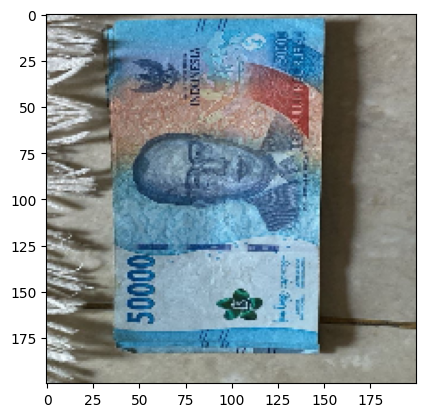

In [45]:
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

img = cv2.imread('fff.jpg')
img = cv2.resize(img, (200, 200))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

# Add a batch dimension
img = np.expand_dims(img, axis=0)

predictions = model.predict(img)
score = tf.nn.softmax(predictions[0])
print(currency_nominal[np.argmax(score)])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(currency_nominal[np.argmax(score)], 100 * np.max(score))
)